In [1]:
from model_helpers import *

import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn
import warnings

warnings.filterwarnings('ignore')

high_cutoff_year = 2022
low_cutoff_year = 2010

In [59]:
def make_test_df(train_df):
    #print(train_df)
    species_sites = train_df['site_id'].unique()
        
    #print(species_sites)
    
    site_ripenesses = []

    for site in species_sites:
        site_df = train_df[train_df['site_id'] == site]

        site_ripenesses.append({
            'site_id': site,
            'doy': np.mean(site_df['doy'])
        })

    species_test_df = pd.DataFrame(site_ripenesses)
    species_test_df['year'] = high_cutoff_year
    
    return species_test_df

# More specific to our uses.
def train_ripeness_small(observations, predictors, test_observations, test_predictors, model_name = 'ThermalTime'):

    print("running model {m}".format(m=model_name))
    Model = utils.load_model(model_name)
    model = Model()
    model.fit(observations, predictors, optimizer_params='practical')
    
    print(model)
    
    print("making predictions for model {m}".format(m=model_name))        
    preds = model.predict(test_observations, test_predictors)

    #print(preds)
    test_days = test_observations.doy.values
    #print(test_days)
   
    # Various error types
    model_mae = mae(test_days, preds)
    model_rmse = rmse(test_days, preds)
    median_error = np.median(np.abs(test_days - preds))

    print('model {m} got a MAE of {a}'.format(m=model_name,a=model_mae))
    print('model {m} got an RMSE of {a}'.format(m=model_name,a=model_rmse))
    print('model {m}\'s median error is: {a}'.format(m=model_name,a=median_error))

    print("Ripeness Day: {}".format(np.mean(preds)))
    
    ripeness_data = test_observations
    ripeness_data['ripeness_day'] = preds
    
    ripeness_dict = {
        'model_object': model,
        'MAE': model_mae,
        'RMSE': model_rmse,
        'Median Error': median_error,
        'prediction_df': ripeness_data,
    }
    
    return ripeness_dict

Idea for corrections: take the lower error between the base error and the year-transformed error.


Best Approach is:
- High time resolution, correcting for missing data by using averaged data from previous years.
- Add European Weather data.
- No southern hemisphere. 
- Corrected error (i.e. date wrapping). 

Best reporting statistic: what portion of results lie under X.
For example, 80% of results lie under 1 STD, 95% lie under 2 STD. 
Can make a "confidence score" from this – percentile error? Ex. This is less error than 90% of things.  

In [28]:
# Load in high-res weather data
print("loading weather data")
grib_data = cfgrib.open_datasets('../data/monthly_weather_data.grib')

core_data = grib_data[0]

print("Loading Plant Data")
formatted_plants = pd.read_csv("../data/model_training_data/all_plants_formatted.csv", index_col=0)

formatted_plants['rounded_lat'] = np.round(formatted_plants['latitude'], 1)
formatted_plants['rounded_lon'] = np.round(formatted_plants['lon_360'], 1)

rounded_sites = formatted_plants[['site_id', 'rounded_lat', 'rounded_lon']].drop_duplicates()

site_x_vals = xr.DataArray(rounded_sites['rounded_lat'], dims=['site'])
site_y_vals = xr.DataArray(rounded_sites['rounded_lon'], dims=['site'])

print("filtering weather data")
full_weather_data = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna()

print("formatting weather data")
formatted_weather = format_weather_data(full_weather_data)

formatted_weather['latitude'] = np.round(formatted_weather['latitude'], 1)
formatted_weather['longitude'] = np.round(formatted_weather['longitude'], 1)

print("adding site IDs to weather data")
rounded_sites['coordstring'] = rounded_sites['rounded_lat'].astype(str) + rounded_sites['rounded_lon'].astype(str)
formatted_weather['coordstring'] = formatted_weather['latitude'].astype(str) + formatted_weather['longitude'].astype(str)

## Add Site ID to the weather data
weather_with_sites = pd.merge(formatted_weather, rounded_sites[['coordstring', 'site_id']], on='coordstring')#.drop('coordstring', axis=1)
## Separate into training data and testing data

# filter out current year
print("separating weather data")
weather_with_sites = weather_with_sites[weather_with_sites['year'] != 2023]

weather_training = weather_with_sites[weather_with_sites['year'] < high_cutoff_year]
weather_test = weather_with_sites[weather_with_sites['year'] >= high_cutoff_year]

# final formatting steps for plants
print("formatting plant data")
species_list = formatted_plants['formatted_sci_name'].unique()
formatted_plants.drop('species', axis=1, inplace=True)

# correct for missing sites
weather_sites = weather_with_sites['site_id'].unique()

print("filtering plant data")
filtered_plants = formatted_plants[(formatted_plants['site_id'].isin(weather_sites)) & 
                                   (formatted_plants['year'] != 2023) &
                                   (formatted_plants['latitude'] > 0) &
                                    (formatted_plants['doy'] >= 60)]


loading weather data
Loading Plant Data
filtering weather data
formatting weather data
formatting date columns
correcting leap years
adding site IDs to weather data
separating weather data
formatting plant data
filtering plant data


TODO: make the europe data rounded to .1 degrees. 

In [4]:
euro_data = load_euro_weather_data(euro_path, '../data/high_res_euro_stations.csv')

In [5]:
## Merge both weather data. 

## If site is in europe data, replace it with the european version. 

# Create a list of "mutual sites".
euro_coords = euro_data['coordstring'].unique()

mutual_sites = weather_with_sites[weather_with_sites['coordstring'].isin(euro_coords)][['site_id', 'coordstring']].drop_duplicates()
# Get those sites from europe
mutual_sites_euro = euro_data[euro_data['coordstring'].isin(mutual_sites['coordstring'])]
mutual_sites_euro = mutual_sites_euro.merge(mutual_sites, on='coordstring')

mutual_sites_euro['temperature'] += 272.5

# Remove those sites from monthly 
unmutual_monthly = weather_with_sites[~weather_with_sites['site_id'].isin(mutual_sites)]

# rbind the two (a union essentially?)
merged_euro = pd.concat([mutual_sites_euro, unmutual_monthly]).drop('station', axis=1).drop_duplicates()

merged_euro['temperature'] = np.round(merged_euro['temperature'], 1)


In [6]:

weather_training = merged_euro[merged_euro['year'] < high_cutoff_year]
weather_test = merged_euro[merged_euro['year'] >= high_cutoff_year]

In [60]:
## Train models

species_prediction_dict = {}

for s in tqdm(species_list):
    print(s)
    species_train_df = filtered_plants.query('formatted_sci_name == "{}" and year < {}'.format(s, high_cutoff_year))
    
    if len(species_train_df) == 0:
        continue
    
    species_test_df = filtered_plants.query('formatted_sci_name == "{}" and year >= {}'.format(s, high_cutoff_year))
    
   # print(species_train_df, species_test_df)
    
    if len(species_test_df) == 0:
        # make predictions and compare to the mean ripeness day at each site
        species_test_df = make_test_df(species_train_df)
    
    if len(species_test_df) == 0:
        print("No test data for {}".format(s))
        #print(species_test_df)
        
    predictions = train_ripeness_small(species_train_df, weather_training,
                        species_test_df, weather_test)
    
    species_prediction_dict[s] = predictions

  0%|                                                                                                                                                                              | 0/97 [00:00<?, ?it/s]

Rubus
running model ThermalTime


  1%|█▋                                                                                                                                                                    | 1/97 [00:03<05:40,  3.55s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 28.6
model ThermalTime got an RMSE of 49.24970389081881
model ThermalTime's median error is: 9.5
Ripeness Day: 187.13333333333333
Rubus occidentalis
running model ThermalTime


  2%|███▍                                                                                                                                                                  | 2/97 [00:07<06:17,  3.97s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 11.7
model ThermalTime got an RMSE of 14.522396496446445
model ThermalTime's median error is: 6.0
Ripeness Day: 192.3
Ficus
running model ThermalTime


  3%|█████▏                                                                                                                                                                | 3/97 [00:11<06:20,  4.05s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.818181818181817
model ThermalTime got an RMSE of 26.460948928219075
model ThermalTime's median error is: 18.0
Ripeness Day: 245.0
Ficus auriculata
Ficus carica
running model ThermalTime


  5%|████████▌                                                                                                                                                             | 5/97 [00:14<03:54,  2.55s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 28.2
model ThermalTime got an RMSE of 39.52214569073901
model ThermalTime's median error is: 13.0
Ripeness Day: 245.0
Ficus citrifolia
running model ThermalTime


  6%|██████████▎                                                                                                                                                           | 6/97 [00:19<04:44,  3.12s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 39.5
model ThermalTime got an RMSE of 39.75550276376844
model ThermalTime's median error is: 39.5
Ripeness Day: 245.0
Ficus macrophylla
running model ThermalTime


  7%|███████████▉                                                                                                                                                          | 7/97 [00:21<04:20,  2.90s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.0
model ThermalTime got an RMSE of 7.0
model ThermalTime's median error is: 7.0
Ripeness Day: 336.0
Ficus sycomorus
Olea europaea
running model ThermalTime


  9%|███████████████▍                                                                                                                                                      | 9/97 [00:23<03:04,  2.09s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 51.76086956521739
model ThermalTime got an RMSE of 61.76480635724381
model ThermalTime's median error is: 45.5
Ripeness Day: 245.0
Olea europea
running model ThermalTime


 10%|█████████████████                                                                                                                                                    | 10/97 [00:27<03:28,  2.40s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.964912280701757
model ThermalTime got an RMSE of 31.763057360170748
model ThermalTime's median error is: 17.5
Ripeness Day: 288.05263157894734
Olea
running model ThermalTime


 11%|██████████████████▋                                                                                                                                                  | 11/97 [00:30<03:51,  2.69s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 38.07692307692308
model ThermalTime got an RMSE of 42.00457850502271
model ThermalTime's median error is: 32.0
Ripeness Day: 306.0
Morus rubra
running model ThermalTime


 12%|████████████████████▍                                                                                                                                                | 12/97 [00:34<04:14,  3.00s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.083333333333334
model ThermalTime got an RMSE of 16.640813281407453
model ThermalTime's median error is: 15.5
Ripeness Day: 165.5
Morus
running model ThermalTime


 13%|██████████████████████                                                                                                                                               | 13/97 [00:38<04:37,  3.31s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.2
model ThermalTime got an RMSE of 30.765936636853056
model ThermalTime's median error is: 15.5
Ripeness Day: 172.28571428571428
Morus macroura
running model ThermalTime


 14%|███████████████████████▊                                                                                                                                             | 14/97 [00:42<04:40,  3.38s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 35.0
model ThermalTime got an RMSE of 35.0
model ThermalTime's median error is: 35.0
Ripeness Day: 183.0
Morus alba
running model ThermalTime
making predictions for model ThermalTime
model ThermalTime got a MAE of 13.185185185185185
model ThermalTime got an RMSE of 18.879736344675063
model ThermalTime's median error is: 7.0
Ripeness Day: 174.11111111111111


 15%|█████████████████████████▌                                                                                                                                           | 15/97 [00:45<04:39,  3.40s/it]

Morus nigra
running model ThermalTime


 16%|███████████████████████████▏                                                                                                                                         | 16/97 [00:49<04:40,  3.46s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.014285714285714
model ThermalTime got an RMSE of 21.45726650145087
model ThermalTime's median error is: 11.5
Ripeness Day: 173.14285714285714
Morus australis
running model ThermalTime


 18%|████████████████████████████▉                                                                                                                                        | 17/97 [00:51<04:17,  3.22s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 19.0
model ThermalTime got an RMSE of 19.0
model ThermalTime's median error is: 19.0
Ripeness Day: 153.0
Amelanchier alnifolia
running model ThermalTime


 19%|██████████████████████████████▌                                                                                                                                      | 18/97 [00:54<03:59,  3.03s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 12.545454545454545
model ThermalTime got an RMSE of 15.397756625265549
model ThermalTime's median error is: 9.0
Ripeness Day: 225.27272727272728
Amelanchier arborea
running model ThermalTime


 20%|████████████████████████████████▎                                                                                                                                    | 19/97 [00:57<03:57,  3.04s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 57.17079674099356
model ThermalTime's median error is: 28.0
Ripeness Day: 169.25
Amelanchier canadensis
running model ThermalTime


 21%|██████████████████████████████████                                                                                                                                   | 20/97 [01:00<03:54,  3.05s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.4
model ThermalTime got an RMSE of 19.979989989987484
model ThermalTime's median error is: 14.0
Ripeness Day: 185.06666666666666
Amelanchier grandiflora
running model ThermalTime


 22%|███████████████████████████████████▋                                                                                                                                 | 21/97 [01:03<03:42,  2.93s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.222222222222221
model ThermalTime got an RMSE of 15.0
model ThermalTime's median error is: 12.5
Ripeness Day: 183.0
Amelanchier laevis
running model ThermalTime


 23%|█████████████████████████████████████▍                                                                                                                               | 22/97 [01:05<03:25,  2.74s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.32
model ThermalTime got an RMSE of 17.24876807195227
model ThermalTime's median error is: 13.0
Ripeness Day: 183.0
Amelanchier utahensis
running model ThermalTime


 24%|███████████████████████████████████████                                                                                                                              | 23/97 [01:08<03:18,  2.69s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 30.875
model ThermalTime got an RMSE of 30.875253035400373
model ThermalTime's median error is: 30.875
Ripeness Day: 245.0
Amelanchier
running model ThermalTime


 25%|████████████████████████████████████████▊                                                                                                                            | 24/97 [01:11<03:26,  2.83s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 12.25
model ThermalTime got an RMSE of 15.15490193407991
model ThermalTime's median error is: 11.5
Ripeness Day: 169.57894736842104
Citrus
running model ThermalTime


 26%|██████████████████████████████████████████▌                                                                                                                          | 25/97 [01:13<03:12,  2.68s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 96.20289855072464
model ThermalTime got an RMSE of 109.66893526572983
model ThermalTime's median error is: 111.0
Ripeness Day: 186.59420289855072
Citrus jambhiri
running model ThermalTime


 27%|████████████████████████████████████████████▏                                                                                                                        | 26/97 [01:16<03:06,  2.63s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 3.0
model ThermalTime got an RMSE of 3.0
model ThermalTime's median error is: 3.0
Ripeness Day: 336.0
Citrus limon
running model ThermalTime


 28%|█████████████████████████████████████████████▉                                                                                                                       | 27/97 [01:18<03:00,  2.58s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 63.0
model ThermalTime got an RMSE of 72.069410986909
model ThermalTime's median error is: 63.0
Ripeness Day: 275.0
Rubus idaeus
running model ThermalTime


 29%|███████████████████████████████████████████████▋                                                                                                                     | 28/97 [01:21<03:06,  2.70s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.125
model ThermalTime got an RMSE of 37.750827805493216
model ThermalTime's median error is: 14.5
Ripeness Day: 217.875
Rubus ellipticus
Rubus hayata
running model ThermalTime


 31%|███████████████████████████████████████████████████                                                                                                                  | 30/97 [01:23<02:11,  1.97s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 11.166666666666666
model ThermalTime got an RMSE of 12.322066926183016
model ThermalTime's median error is: 10.0
Ripeness Day: 214.0
Rubus odoratus
Rubus phoenicolasius
running model ThermalTime


 33%|██████████████████████████████████████████████████████▍                                                                                                              | 32/97 [01:26<01:47,  1.65s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 26.007691170113507
model ThermalTime's median error is: 10.0
Ripeness Day: 195.4
Rubus rolfei
running model ThermalTime


 34%|████████████████████████████████████████████████████████▏                                                                                                            | 33/97 [01:28<01:54,  1.79s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 11.0
model ThermalTime got an RMSE of 11.0
model ThermalTime's median error is: 11.0
Ripeness Day: 214.0
Citrus aurantium
running model ThermalTime


 35%|█████████████████████████████████████████████████████████▊                                                                                                           | 34/97 [01:30<02:00,  1.91s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.5
model ThermalTime got an RMSE of 13.5
model ThermalTime's median error is: 13.5
Ripeness Day: 336.0
Citrus sinensis
running model ThermalTime


 36%|███████████████████████████████████████████████████████████▌                                                                                                         | 35/97 [01:34<02:28,  2.40s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 28.0
model ThermalTime got an RMSE of 34.45770354120154
model ThermalTime's median error is: 26.0
Ripeness Day: 275.0
Prunus americana
running model ThermalTime


 37%|█████████████████████████████████████████████████████████████▏                                                                                                       | 36/97 [01:38<02:46,  2.73s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 40.77777777777778
model ThermalTime got an RMSE of 48.546197928708416
model ThermalTime's median error is: 37.0
Ripeness Day: 218.13333333333333
Prunus domestica
running model ThermalTime


 38%|██████████████████████████████████████████████████████████████▉                                                                                                      | 37/97 [01:41<02:47,  2.79s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.57894736842105
model ThermalTime got an RMSE of 28.653097563788805
model ThermalTime's median error is: 15.0
Ripeness Day: 240.10526315789474
Prunus maritima
running model ThermalTime


 39%|████████████████████████████████████████████████████████████████▋                                                                                                    | 38/97 [01:43<02:35,  2.63s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 19.625
model ThermalTime got an RMSE of 24.902309129877896
model ThermalTime's median error is: 14.5
Ripeness Day: 245.0
Prunus nigra
running model ThermalTime


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                  | 39/97 [01:47<02:50,  2.94s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 55.0
model ThermalTime got an RMSE of 55.0
model ThermalTime's median error is: 55.0
Ripeness Day: 275.0
Prunus cerasifera
running model ThermalTime


 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 40/97 [01:50<03:01,  3.18s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.642857142857142
model ThermalTime got an RMSE of 18.33225105030554
model ThermalTime's median error is: 13.5
Ripeness Day: 214.0
Prunus
running model ThermalTime


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                               | 41/97 [01:54<03:08,  3.37s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 32.07692307692308
model ThermalTime got an RMSE of 41.56582669354657
model ThermalTime's median error is: 29.0
Ripeness Day: 202.07692307692307
Prunus angustifolia
running model ThermalTime


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                             | 42/97 [01:57<02:52,  3.14s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.0
model ThermalTime got an RMSE of 25.0
model ThermalTime's median error is: 25.0
Ripeness Day: 183.0
Prunus cocomilia
running model ThermalTime


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 43/97 [02:03<03:46,  4.19s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.0
model ThermalTime got an RMSE of 15.264337522473747
model ThermalTime's median error is: 13.0
Ripeness Day: 245.0
Prunus salicina
running model ThermalTime


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                          | 44/97 [02:07<03:37,  4.11s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 32.0
model ThermalTime got an RMSE of 32.0
model ThermalTime's median error is: 32.0
Ripeness Day: 214.0
Prunus subcordata
running model ThermalTime


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                        | 45/97 [02:10<03:12,  3.71s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 8.0
model ThermalTime got an RMSE of 8.0
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0
Prunus mexicana
running model ThermalTime


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                      | 46/97 [02:13<02:51,  3.36s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 12.166666666666666
model ThermalTime got an RMSE of 13.729530217745982
model ThermalTime's median error is: 8.5
Ripeness Day: 275.0
Prunus rivularis
running model ThermalTime


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                     | 47/97 [02:17<02:58,  3.58s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 11.0
model ThermalTime got an RMSE of 11.0
model ThermalTime's median error is: 11.0
Ripeness Day: 214.0
Eriobotrya japonica
running model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 48/97 [02:20<02:53,  3.54s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.67741935483871
model ThermalTime got an RMSE of 50.158458586184004
model ThermalTime's median error is: 49.0
Ripeness Day: 122.0
Malus sieboldii
running model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 49/97 [02:23<02:36,  3.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 81.1
model ThermalTime got an RMSE of 101.5297985815002
model ThermalTime's median error is: 56.0
Ripeness Day: 275.0
Malus
running model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 50/97 [02:25<02:21,  3.01s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 36.97424892703863
model ThermalTime got an RMSE of 46.04005533531612
model ThermalTime's median error is: 32.0
Ripeness Day: 248.21888412017168
Malus pumila
running model ThermalTime


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 51/97 [02:28<02:08,  2.80s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 29.970588235294116
model ThermalTime got an RMSE of 41.954106578778784
model ThermalTime's median error is: 24.0
Ripeness Day: 268.8235294117647
Malus domestica
running model ThermalTime


 54%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 52/97 [02:39<03:57,  5.29s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.50133610334564
model ThermalTime got an RMSE of 18.45386367754061
model ThermalTime's median error is: 9.5
Ripeness Day: 244.89441416893732
Malus fusca
Malus sylvestris
running model ThermalTime


 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 54/97 [02:41<02:28,  3.46s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 14.0
model ThermalTime's median error is: 14.0
Ripeness Day: 245.0
Malus coronaria
running model ThermalTime


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 55/97 [02:44<02:17,  3.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.0
model ThermalTime got an RMSE of 41.0
model ThermalTime's median error is: 41.0
Ripeness Day: 275.0
Malus '
running model ThermalTime


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 56/97 [02:46<02:05,  3.05s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 8.0
model ThermalTime got an RMSE of 8.0
model ThermalTime's median error is: 8.0
Ripeness Day: 245.0
Malus sieversii
running model ThermalTime


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 57/97 [02:49<02:00,  3.01s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 19.0
model ThermalTime got an RMSE of 19.0
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0
Malus baccata
running model ThermalTime


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 58/97 [02:52<01:50,  2.84s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 26.5
model ThermalTime got an RMSE of 26.504716561397142
model ThermalTime's median error is: 26.5
Ripeness Day: 275.0
Malus ioensis
running model ThermalTime


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 59/97 [02:54<01:43,  2.73s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.0
model ThermalTime got an RMSE of 13.0
model ThermalTime's median error is: 13.0
Ripeness Day: 245.0
Malus hupehensis
running model ThermalTime


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 60/97 [02:57<01:37,  2.62s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 34.0
model ThermalTime got an RMSE of 34.0
model ThermalTime's median error is: 34.0
Ripeness Day: 245.0
Malus tschonoskii
running model ThermalTime


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 61/97 [02:59<01:33,  2.61s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 0.0
model ThermalTime got an RMSE of 0.0
model ThermalTime's median error is: 0.0
Ripeness Day: 245.0
Malus angustifolia
running model ThermalTime


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 62/97 [03:02<01:31,  2.61s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 11.0
model ThermalTime got an RMSE of 11.0
model ThermalTime's median error is: 11.0
Ripeness Day: 306.0
Rosmarinus officinalis
running model ThermalTime


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 63/97 [03:04<01:26,  2.53s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 89.3076923076923
model ThermalTime got an RMSE of 97.03647212814842
model ThermalTime's median error is: 90.0
Ripeness Day: 185.3846153846154
Juglans
running model ThermalTime


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/97 [03:06<01:21,  2.48s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.0
model ThermalTime got an RMSE of 20.334699407662754
model ThermalTime's median error is: 16.5
Ripeness Day: 275.0
Juglans regia
running model ThermalTime


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 65/97 [03:09<01:19,  2.49s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 55.333333333333336
model ThermalTime got an RMSE of 56.13079962611139
model ThermalTime's median error is: 62.0
Ripeness Day: 245.0
Juglans cinerea
running model ThermalTime


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 66/97 [03:12<01:17,  2.50s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 10.666666666666666
model ThermalTime got an RMSE of 17.339742404853272
model ThermalTime's median error is: 1.0
Ripeness Day: 275.0
Juglans hindsii
running model ThermalTime


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 67/97 [03:14<01:14,  2.48s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 24.0
model ThermalTime got an RMSE of 24.0
model ThermalTime's median error is: 24.0
Ripeness Day: 306.0
Juglans major
running model ThermalTime


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 68/97 [03:16<01:11,  2.47s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 10.5
model ThermalTime got an RMSE of 11.113055385446435
model ThermalTime's median error is: 12.0
Ripeness Day: 306.0
Juglans nigra
running model ThermalTime


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 69/97 [03:19<01:13,  2.62s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 19.923076923076923
model ThermalTime got an RMSE of 28.42128130062455
model ThermalTime's median error is: 16.0
Ripeness Day: 277.38461538461536
Prunus serotina
running model ThermalTime


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 70/97 [03:23<01:16,  2.82s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 17.97222222222222
model ThermalTime got an RMSE of 24.77846287044905
model ThermalTime's median error is: 13.0
Ripeness Day: 211.41666666666666
Prunus virginiana
running model ThermalTime


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 71/97 [03:25<01:09,  2.67s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 17.433333333333334
model ThermalTime got an RMSE of 20.809452980156237
model ThermalTime's median error is: 15.5
Ripeness Day: 239.83333333333334
Prunus yedoensis
running model ThermalTime


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 72/97 [03:28<01:08,  2.74s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.0
model ThermalTime got an RMSE of 21.213203435596427
model ThermalTime's median error is: 21.0
Ripeness Day: 183.0
Prunus ilicifolia
running model ThermalTime


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 73/97 [03:30<01:02,  2.62s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 65.0
model ThermalTime got an RMSE of 65.0
model ThermalTime's median error is: 65.0
Ripeness Day: 183.0
Prunus cerasus
running model ThermalTime


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 74/97 [03:34<01:05,  2.84s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.90909090909091
model ThermalTime got an RMSE of 55.62291875575293
model ThermalTime's median error is: 26.0
Ripeness Day: 183.0
Prunus emarginata
running model ThermalTime


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/97 [03:36<00:58,  2.67s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 36.0574074074074
model ThermalTime got an RMSE of 51.998492479730686
model ThermalTime's median error is: 11.422222222222217
Ripeness Day: 245.0
Prunus pensylvanica
running model ThermalTime


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 76/97 [03:38<00:54,  2.57s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.833333333333332
model ThermalTime got an RMSE of 19.710403344427025
model ThermalTime's median error is: 18.0
Ripeness Day: 214.0
Prunus laurocerasus
running model ThermalTime


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 77/97 [03:41<00:52,  2.62s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.625
model ThermalTime got an RMSE of 8.338540040078959
model ThermalTime's median error is: 7.625
Ripeness Day: 214.0
Prunus serrulata
running model ThermalTime


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/97 [03:44<00:54,  2.89s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 9.0
model ThermalTime got an RMSE of 9.848857801796104
model ThermalTime's median error is: 9.0
Ripeness Day: 229.5
Prunus avium
running model ThermalTime


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 79/97 [03:52<01:17,  4.30s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.4
model ThermalTime got an RMSE of 33.97204733306487
model ThermalTime's median error is: 6.5
Ripeness Day: 172.5
Cornus mas
running model ThermalTime


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 80/97 [03:54<01:03,  3.74s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.666666666666668
model ThermalTime got an RMSE of 26.595739007091595
model ThermalTime's median error is: 32.0
Ripeness Day: 234.66666666666666
Ehretia tinifolia
running model ThermalTime


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 81/97 [03:57<00:53,  3.34s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 5.0
model ThermalTime got an RMSE of 5.0
model ThermalTime's median error is: 5.0
Ripeness Day: 153.0
Elaeagnus multiflora
running model ThermalTime


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 82/97 [03:59<00:46,  3.07s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 1.0
model ThermalTime got an RMSE of 1.0
model ThermalTime's median error is: 1.0
Ripeness Day: 183.0
Eugenia brasiliensis
Prunus fruticosa
running model ThermalTime


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/97 [04:02<00:28,  2.18s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 61.0
model ThermalTime got an RMSE of 62.369864518050704
model ThermalTime's median error is: 61.0
Ripeness Day: 214.0
Prunus maackii
running model ThermalTime


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 85/97 [04:04<00:27,  2.33s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.0
model ThermalTime got an RMSE of 13.0
model ThermalTime's median error is: 13.0
Ripeness Day: 183.0
Prunus mahaleb
Prunus padus
running model ThermalTime


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 87/97 [04:07<00:18,  1.82s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 4.0
model ThermalTime got an RMSE of 4.0
model ThermalTime's median error is: 4.0
Ripeness Day: 183.0
Prunus subhirtella
Prunus tomentosa
running model ThermalTime


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 89/97 [04:10<00:14,  1.78s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 28.75
model ThermalTime got an RMSE of 33.3878720495931
model ThermalTime's median error is: 28.5
Ripeness Day: 206.25
Diospyros virginiana
running model ThermalTime


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 90/97 [04:13<00:14,  2.13s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 24.658227848101266
model ThermalTime got an RMSE of 41.89015170808745
model ThermalTime's median error is: 16.0
Ripeness Day: 282.45569620253167
Diospyros
running model ThermalTime


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 91/97 [04:16<00:13,  2.21s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 30.0
model ThermalTime got an RMSE of 34.47221103052912
model ThermalTime's median error is: 36.0
Ripeness Day: 306.0
Diospyros kaki
running model ThermalTime


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 92/97 [04:19<00:12,  2.51s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 19.142857142857142
model ThermalTime got an RMSE of 20.96936541038583
model ThermalTime's median error is: 18.0
Ripeness Day: 306.0
Pyrus communis
running model ThermalTime


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 93/97 [04:23<00:11,  2.79s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 27.75
model ThermalTime got an RMSE of 31.298961644118485
model ThermalTime's median error is: 31.5
Ripeness Day: 245.0
Pyrus
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 94/97 [04:26<00:08,  2.78s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 27.066666666666666
model ThermalTime got an RMSE of 33.50223873116541
model ThermalTime's median error is: 21.0
Ripeness Day: 247.0
Pyrus amygdaliformis
running model ThermalTime


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 95/97 [04:28<00:05,  2.69s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.666666666666666
model ThermalTime got an RMSE of 20.37154878746336
model ThermalTime's median error is: 4.0
Ripeness Day: 275.0
Pyrus pyraster
running model ThermalTime


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 96/97 [04:31<00:02,  2.67s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 10.0
model ThermalTime got an RMSE of 10.770329614269007
model ThermalTime's median error is: 10.0
Ripeness Day: 275.0
Pyrus pyrifolia
running model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [04:33<00:00,  2.82s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.0
model ThermalTime got an RMSE of 31.0
model ThermalTime's median error is: 31.0
Ripeness Day: 275.0


In [61]:
for s in species_prediction_dict.keys():
    print(s, species_prediction_dict[s]['Median Error'])

Rubus 9.5
Rubus occidentalis 6.0
Ficus 18.0
Ficus carica 13.0
Ficus citrifolia 39.5
Ficus macrophylla 7.0
Olea europaea 45.5
Olea europea 17.5
Olea 32.0
Morus rubra 15.5
Morus 15.5
Morus macroura 35.0
Morus alba 7.0
Morus nigra 11.5
Morus australis 19.0
Amelanchier alnifolia 9.0
Amelanchier arborea 28.0
Amelanchier canadensis 14.0
Amelanchier grandiflora 12.5
Amelanchier laevis 13.0
Amelanchier utahensis 30.875
Amelanchier 11.5
Citrus 111.0
Citrus jambhiri 3.0
Citrus limon 63.0
Rubus idaeus 14.5
Rubus hayata 10.0
Rubus phoenicolasius 10.0
Rubus rolfei 11.0
Citrus aurantium 13.5
Citrus sinensis 26.0
Prunus americana 37.0
Prunus domestica 15.0
Prunus maritima 14.5
Prunus nigra 55.0
Prunus cerasifera 13.5
Prunus 29.0
Prunus angustifolia 25.0
Prunus cocomilia 13.0
Prunus salicina 32.0
Prunus subcordata 8.0
Prunus mexicana 8.5
Prunus rivularis 11.0
Eriobotrya japonica 49.0
Malus sieboldii 56.0
Malus 32.0
Malus pumila 24.0
Malus domestica 9.5
Malus sylvestris 14.0
Malus coronaria 41.0
Malus 

TODO for tomorrow: figure out why it's still defaulting to monthly instead of taking some euro data. 

In [74]:
# gets a list of all the prediction dataframes from the species model
df_list = [i['prediction_df'] for i in species_prediction_dict.values()]

full_prediction_df = pd.concat(df_list)

full_prediction_df['abs_error'] = np.abs(full_prediction_df['doy'] - full_prediction_df['flowering_day'])

In [69]:
full_prediction_df

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day
19,1812903,42.000443,183.0,2022.0,Rubus,268.349632,516.0,Rubus,42.0,268.3,183
20,1812992,43.123822,181.0,2022.0,Rubus,282.422069,516.0,Rubus,43.1,282.4,183
22,1813012,35.219765,190.0,2022.0,Rubus,270.150501,516.0,Rubus,35.2,270.2,183
23,1813095,43.026309,193.0,2022.0,Rubus,274.317216,516.0,Rubus,43.0,274.3,183
25,1810562,37.417095,165.0,2022.0,Rubus,280.809241,516.0,Rubus,37.4,280.8,183
...,...,...,...,...,...,...,...,...,...,...,...
1,1759647,NaN,240.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275
2,1760749,NaN,271.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275
0,1769198,NaN,261.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275
1,1718728,NaN,281.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275


In [98]:
## STATS

# get confidence intervals for species

def calc_confidence_interval():
    pass

def score_model(prediction_df):
    observed = prediction_df['doy']
    predicted = prediction_df['flowering_day']
    
    median_err = np.median(prediction_df['abs_error'])
    std = np.std(prediction_df['abs_error'])
    
    # MAE, RMSE, median
    print("Error metrics:")
    print(mae(observed, predicted))
    print(rmse(observed, predicted))
    print(median_err)
    
    # portion of errors under the median
    print("Median portion (median error = {})".format(median_err))
    print(len(prediction_df.query('abs_error < {}'.format(median_err))) / len(prediction_df))
    
    # portion of errors under the SD
    print("SD portion (SD = {})".format(std))
    print(len(prediction_df.query('abs_error < {}'.format(std))) / len(prediction_df))
    
    print("Month threshold:")
    print(len(prediction_df.query('abs_error < 30')) / len(prediction_df))

    # 
    print("2 * SD portion (2SD = {})".format(2 * std))
    print(len(prediction_df.query('abs_error < {}'.format(2 * std))) / len(prediction_df))
    

# get how "good" one sample is compared to the whole sample
def calc_error_percentile(sample, full_sample):
    sample_median = np.median(sample['abs_error'])
    
    print(sample_median)
    print(1 - len(full_sample.query('abs_error < {}'.format(sample_median))) / len(full_sample))

(array([  2.,   1.,   0.,   0.,   1.,   2.,   1.,   0.,   1.,   1.,   0.,
          1.,   0.,  12.,   3.,   3.,   4.,   5.,   8.,  16.,  27.,  48.,
         60., 106., 143., 258., 337., 512., 439., 259., 136., 128.,  98.,
         61.,  34.,  26.,  19.,  19.,   7.,  17.,  10.,   5.,   1.,   5.,
          2.,  13.,   6.,   4.,   5.,   3.]),
 array([-213.  , -205.26, -197.52, -189.78, -182.04, -174.3 , -166.56,
        -158.82, -151.08, -143.34, -135.6 , -127.86, -120.12, -112.38,
        -104.64,  -96.9 ,  -89.16,  -81.42,  -73.68,  -65.94,  -58.2 ,
         -50.46,  -42.72,  -34.98,  -27.24,  -19.5 ,  -11.76,   -4.02,
           3.72,   11.46,   19.2 ,   26.94,   34.68,   42.42,   50.16,
          57.9 ,   65.64,   73.38,   81.12,   88.86,   96.6 ,  104.34,
         112.08,  119.82,  127.56,  135.3 ,  143.04,  150.78,  158.52,
         166.26,  174.  ]),
 <BarContainer object of 50 artists>)

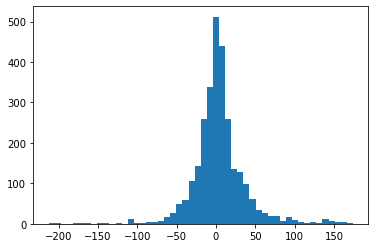

In [100]:
plt.hist(full_prediction_df['doy'] - full_prediction_df['flowering_day'], bins=50)

In [99]:
for g in full_prediction_df['genus'].dropna().unique():
    g_df = full_prediction_df[full_prediction_df['genus'] == g]
    print(g)
    calc_error_percentile(g_df, full_prediction_df)

Rubus
10.0
0.6075816075816076
Ficus
16.0
0.44120744120744115
Olea
41.0
0.14215514215514213
Morus
13.0
0.5135135135135135
Amelanchier
13.0
0.5135135135135135
Citrus
110.0
0.02211302211302213
Prunus
19.0
0.3783783783783784
Eriobotrya
49.0
0.10810810810810811
Malus
30.0
0.23727623727623726
Rosmarinus
90.0
0.03404703404703402
Juglans
16.0
0.44120744120744115
Cornus
32.0
0.2169182169182169
Diospyros
17.5
0.40400140400140405
Pyrus
28.0
0.2628992628992629


In [84]:
score_model(full_prediction_df)

Error metrics:
21.891178292476994
34.257129283602936
13.0
Median portion (median error = 13.0)
0.4864864864864865
SD portion (SD = 26.35008955811099)
0.7237627237627238
Month threshold:
0.7627237627237627
2 * SD portion (2SD = 52.70017911622198)
0.9143559143559143


In [85]:
np.std(full_prediction_df['abs_error'])

26.35008955811099

(array([470., 425., 304., 309., 200., 180., 106., 135., 102., 114.,  74.,
         57.,  38.,  56.,  45.,  22.,  24.,  15.,  17.,  10.,  17.,  11.,
          8.,   9.,   2.,  14.,   5.,   6.,   6.,   3.,   5.,  11.,   1.,
          0.,   6.,   0.,   1.,   1.,   6.,   8.,   0.,   1.,   6.,   2.,
          2.,   4.,   2.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   2.]),
 array([  0.  ,   3.55,   7.1 ,  10.65,  14.2 ,  17.75,  21.3 ,  24.85,
         28.4 ,  31.95,  35.5 ,  39.05,  42.6 ,  46.15,  49.7 ,  53.25,
         56.8 ,  60.35,  63.9 ,  67.45,  71.  ,  74.55,  78.1 ,  81.65,
         85.2 ,  88.75,  92.3 ,  95.85,  99.4 , 102.95, 106.5 , 110.05,
        113.6 , 117.15, 120.7 , 124.25, 127.8 , 131.35, 134.9 , 138.45,
        142.  , 145.55, 149.1 , 152.65, 156.2 , 159.75, 163.3 , 166.85,
        170.4 , 173.95, 177.5 , 181.05, 184.6 , 188.15, 191.7 , 195.25,
        198.8 , 202.35, 205.9 , 209.45, 213.  ]),
 <BarContainer object of 60 artists>

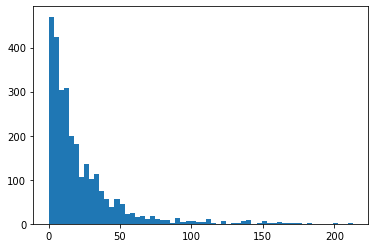

In [86]:
plt.hist(full_prediction_df['abs_error'], bins=60)

In [102]:
full_prediction_df[full_prediction_df['abs_error'] >= 100].sort_values('abs_error', ascending=False)[0:50]

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error
36,8,39.910755,62.0,2022.0,Diospyros,273.575810,516.0,Diospyros virginiana,39.9,273.6,275,213.0
50,2,38.376015,63.0,2022.0,Malus,237.491870,516.0,Malus sieboldii,38.4,237.5,275,212.0
46,8,39.910755,75.0,2022.0,Diospyros,273.575810,516.0,Diospyros virginiana,39.9,273.6,275,200.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516.0,Malus,43.0,281.2,245,182.0
182,1824168,32.078188,357.0,2022.0,Citrus,34.802053,516.0,Citrus,32.1,34.8,183,174.0
193,1824165,32.026304,356.0,2022.0,Citrus,278.925524,516.0,Citrus,32.0,278.9,183,173.0
492,4,34.051340,73.0,2022.0,Olea,241.796875,516.0,Olea europaea,34.1,241.8,245,172.0
98,1823026,33.922294,289.0,2022.0,Eriobotrya,241.593083,516.0,Eriobotrya japonica,33.9,241.6,122,167.0
324869,3096,39.997452,108.0,2022.0,Malus,254.717300,516.0,Malus pumila,40.0,254.7,275,167.0
413,1824101,32.056094,349.0,2022.0,Citrus,34.799296,516.0,Citrus,32.1,34.8,183,166.0


In [103]:
full_prediction_df

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error
19,1812903,42.000443,183.0,2022.0,Rubus,268.349632,516.0,Rubus,42.0,268.3,183,0.0
20,1812992,43.123822,181.0,2022.0,Rubus,282.422069,516.0,Rubus,43.1,282.4,183,2.0
22,1813012,35.219765,190.0,2022.0,Rubus,270.150501,516.0,Rubus,35.2,270.2,183,7.0
23,1813095,43.026309,193.0,2022.0,Rubus,274.317216,516.0,Rubus,43.0,274.3,183,10.0
25,1810562,37.417095,165.0,2022.0,Rubus,280.809241,516.0,Rubus,37.4,280.8,183,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1,1759647,NaN,240.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,35.0
2,1760749,NaN,271.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,4.0
0,1769198,NaN,261.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,14.0
1,1718728,NaN,281.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,6.0


In [104]:
74 / 2849

0.025974025974025976

In [ ]:
genus_prediction_dict = {}

for s in tqdm(filtered_plants['genus'].unique()):
    print(s)
    species_train_df = filtered_plants.query('genus == "{}" and year < {}'.format(s, high_cutoff_year))
    
    if len(species_train_df) == 0:
        continue
    
    species_test_df = filtered_plants.query('genus == "{}" and year >= {}'.format(s, high_cutoff_year))
    
    if len(species_test_df) == 0:
        # make predictions and compare to the mean ripeness day at each site
        species_test_df = make_test_df(species_train_df)
    
    if len(species_test_df) == 0:
        print("No test data for {}".format(s))
        #print(species_test_df)
        
    predictions = train_ripeness_small(species_train_df, weather_training,
                        species_test_df, weather_test)
    
    genus_prediction_dict[s] = predictions